##### 0. In this notebook , we are going to train classifiers on a subset of features which were selected during feature selection process

### 1. Setup and import required packages

In [1]:
import os
import joblib
import shutil
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from models import AdaBoost
from models import KNearestNeighbors
from models import LogisticRegression
from models import MultiLayerPerceptron
from models import SupportVectorMachine

import sys
sys.path.insert(1, os.path.join("..", "Audio_Scripts"))
sys.path.insert(1, os.path.join(".."))
from Audio_Scripts import audio_utils as au
from Audio_Scripts import preprocessing
from Audio_Scripts import featrue_extraction
import librosa
import soundfile as sf
from tqdm import tqdm

<h3>2. Read train Data.</h3>

In [2]:
train_data = os.path.join("train", "train_features.csv")

train_df = pd.read_csv(train_data)

print("Num train samples:", len(train_df))

Num train samples: 14245


In [3]:
list(train_df.columns)

['spectral_centroid_1',
 'zcr',
 'spectral_contrast_1',
 'spectral_contrast_2',
 'spectral_contrast_3',
 'spectral_contrast_4',
 'spectral_contrast_5',
 'spectral_contrast_6',
 'spectral_contrast_7',
 'bandwidth_1',
 'energy_1',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'log_mel_1',
 'log_mel_2',
 'log_mel_3',
 'log_mel_4',
 'log_mel_5',
 'log_mel_6',
 'log_mel_7',
 'log_mel_8',
 'log_mel_9',
 'log_mel_10',
 'log_mel_11',
 'log_mel_12',
 'log_mel_13',
 'log_mel_14',
 'log_mel_15',
 'log_mel_16',
 'log_mel_17',
 'log_mel_18',
 'log_mel_19',
 'log_mel_20',
 'log_mel_21',
 'log_mel_22',
 'log_mel_23',
 'log_mel_24',
 'log_mel_25',
 'log_mel_26',
 'log_mel_27',
 'log_mel_28',
 'log_mel_29',
 'log_mel_30',
 'log_mel_31',
 'log_mel_32',
 'log_mel_33',
 'log_mel_34',
 'log_mel_35',
 'log_mel_36',
 'log_mel_37',
 'log_mel_38',
 'log_mel_39',
 'log_mel_40',
 'label']

<h3>3. Extract required features.</h3>

In [4]:
MFCC_columns = ['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
                'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']

Sp_contrast_columns = ['spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
                       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6', 'spectral_contrast_7']

selected_features = MFCC_columns + Sp_contrast_columns + ['label']

x_train_selected = train_df[selected_features]

In [5]:
x_train, y_train = np.array(x_train_selected.drop("label", axis=1)), np.array(train_df['label'])

col_mean = np.nanmean(x_train, axis=0)
inds = np.where(np.isnan(x_train))
x_train[inds] = np.take(col_mean, inds[1])

# Scale features
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)

In [6]:
models = {
    "svm": SupportVectorMachine(),
    "mlp": MultiLayerPerceptron(),
    "log": LogisticRegression(),
    "knn": KNearestNeighbors(),
    "ada": AdaBoost(),
}

for model_name, model in models.items():
    print(f"Train and evaluate {model_name}.")
    scores = model.cross_validate(x_train_scaled, y_train)
    print(f"\tCross val score: {scores}")
    print("-"*20)

Train and evaluate svm.
	Cross val score: [0.97507898 0.97542998 0.96911197 0.97402597 0.97683398]
--------------------
Train and evaluate mlp.
	Cross val score: [0.98244998 0.98455598 0.97297297 0.97191997 0.97964198]
--------------------
Train and evaluate log.
	Cross val score: [0.93997894 0.93646894 0.93155493 0.93752194 0.93295893]
--------------------
Train and evaluate knn.
	Cross val score: [0.97893998 0.98069498 0.97437697 0.97507898 0.97648298]
--------------------
Train and evaluate ada.
	Cross val score: [0.91786592 0.91962092 0.91681292 0.90768691 0.90698491]
--------------------


### 4. Modify the inference function

In [7]:
from Audio_Scripts.extraction_methods import mfcc_extraction
from Audio_Scripts.extraction_methods import spectral_contrast_extraction

def detect_gender(audio_path, model):
    # Load Model and scaler
    if isinstance(model, str):
        model = joblib.load(model)
    if not hasattr(model, "predict"):
        raise ValueError(f"Model {model} not supported")

    if not audio_path.endswith(".wav") and not audio_path.endswith(".mp3"):
        raise ValueError(f"Audio path {audio_path} not supported")

    scaler = joblib.load(os.path.join("saved_models", "std_scaler_2.joblib"))

    temp_dir = "./.temp.inference_cache"
    os.makedirs(temp_dir, exist_ok=True)

    # Split audio into 3 seconds chunks (maximum 1 min)
    audio, sr = librosa.load(audio_path, sr=samping_rate)
    filtered_audio = preprocessing.bandpass_filter(audio, sr, lowcut, highcut)
    normalized_audio = preprocessing.normalize_audio(filtered_audio, sr, target_lufs=-14)
    non_silent_audio = preprocessing.remove_silence(normalized_audio, threshold=0.05)
    if non_silent_audio.size <= 0:
        raise ValueError(f"file `{audio_path}` is a silent file.")

    num_samples_per_segment = sr * segment_duration
    total_segments = min(5, len(normalized_audio) // num_samples_per_segment)  # maximum 15 seconds per person
    for i in range(total_segments):
        start = i * num_samples_per_segment
        end = start + num_samples_per_segment
        segment = normalized_audio[start:end]
        segment_file = os.path.join(temp_dir, f"segment_{i}.wav")
        sf.write(segment_file, segment, sr)

    # Extract features and run model
    chunks = [os.path.join(temp_dir, f"segment_{i}.wav") for i in range(total_segments)]
    results = []
    for chunk_name in tqdm(chunks):
        #energy, _ = energy_extraction.extract_energy(chunk_name, sr=samping_rate, hop_length=hop_length)
        #energy_features = list(np.mean(energy, axis=1))
        mfcc_features = mfcc_extraction.extract_mfcc(chunk_name, n_mfcc=13)
        mfcc_features = list(mfcc_features)
        spectral_contrast = spectral_contrast_extraction.extract_spectral_contrast(audio_path, sr=samping_rate)
        spectral_contrast_features = list(spectral_contrast)
        #spectral_bandwidth = spectral_bandwidth_extraction.extract_spectral_bandwidth(audio_path, sr=samping_rate)
        #spectral_bandwidth_features = list(spectral_bandwidth)
        #mel_spectrogram = log_mel_spectrogram_extraction.extract_log_mel_spectrogram(audio_path, n_mels=40,
        #                                                                             n_fft=1024, hop_length=hop_length)
        #mel_spectrogram_features = list(mel_spectrogram)
        #spectral_centroid = spectral_centroid_extraction.extract_spectral_centroid(audio_path, sr=samping_rate)
        #spectral_centroid_features = list(spectral_centroid)
        #zero = zcr_extraction.extract_zero_crossing_rate(audio_path, sr=samping_rate)
        #zero_features = [zero]

        #all_features = energy_features + mfcc_features + spectral_contrast_features + spectral_bandwidth_features + mel_spectrogram_features + spectral_centroid_features + zero_features
        all_features = mfcc_features + spectral_contrast_features
        all_features = np.array(all_features)

        features_ready = scaler.transform([all_features])
        prediction = model.predict(features_ready)
        results.append(list(prediction)[0])
    shutil.rmtree(temp_dir)
    return 1 if sum(results) > len(results) // 2 else 0

### 5. Evaluate the model on unseen data

In [8]:
samping_rate = 22050
hop_length = 512
lowcut, highcut = 50.0, 5000.0
segment_duration = 3

In [9]:
svm = SupportVectorMachine()
svm.train(x_train_scaled, y_train)

In [10]:
joblib.dump(svm, os.path.join("saved_models", "svm_3.joblib"))

['saved_models/svm_3.joblib']

In [11]:
test_data_path = os.path.join(".", "test", "raw")


test_data = [os.path.join(test_data_path, t) for t in os.listdir(test_data_path)]
test_data = [(t, 0 if "female" in t else 1) for t in test_data]
test_data

[('./test/raw/hw1_q2_610399205_male.mp3', 1),
 ('./test/raw/hw1_q1a_810103262_male.mp3', 1),
 ('./test/raw/hw1_q5_810103262_male.mp3', 1),
 ('./test/raw/hw1_q6_810103108_male.mp3', 1),
 ('./test/raw/hw1_q4_810103222_male.mp3', 1),
 ('./test/raw/hw1_intro_810103222_male.mp3', 1),
 ('./test/raw/hw1_q1_610300070_female.mp3', 0),
 ('./test/raw/hw1_intro_810103172_male.mp3', 1),
 ('./test/raw/hw1_q5_610399205_male.mp3', 1),
 ('./test/raw/hw1_intro_810103197_female.mp3', 0),
 ('./test/raw/hw1_q6_810100268_female.mp3', 0),
 ('./test/raw/hw1_q2_810199570_female.mp3', 0),
 ('./test/raw/hw1_q2_810103108_male.mp3', 1),
 ('./test/raw/hw1_q1_810102066_male.mp3', 1),
 ('./test/raw/hw1_intro_810100268_female.mp3', 0),
 ('./test/raw/hw1_intro_810101423_male.mp3', 1),
 ('./test/raw/hw1_q5_810103093_female.mp3', 0),
 ('./test/raw/hw1_q1_810199328_male.mp3', 1),
 ('./test/raw/hw1_q4_610300070_female.mp3', 0),
 ('./test/raw/hw1_q2_810103093_female.mp3', 0),
 ('./test/raw/hw1_q5_810199328_male.mp3', 1),
 (

In [12]:
TP, TN, FP, FN = 0, 0, 0, 0
for i, (test_file, label) in enumerate(test_data):
    print(f"{i+1}/{len(test_data)}: {test_file}")
    prediction = detect_gender(test_file, 'saved_models/svm_3.joblib')
    
    if prediction == 1:
        if label == 1:
            TP += 1
        else:
            FP += 1
    else:
        if label == 0:
            TN += 1
        else:
            FN += 1


1/30: ./test/raw/hw1_q2_610399205_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


2/30: ./test/raw/hw1_q1a_810103262_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


3/30: ./test/raw/hw1_q5_810103262_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


4/30: ./test/raw/hw1_q6_810103108_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


5/30: ./test/raw/hw1_q4_810103222_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


6/30: ./test/raw/hw1_intro_810103222_male.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.96it/s]


7/30: ./test/raw/hw1_q1_610300070_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


8/30: ./test/raw/hw1_intro_810103172_male.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.56it/s]


9/30: ./test/raw/hw1_q5_610399205_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


10/30: ./test/raw/hw1_intro_810103197_female.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.54it/s]


11/30: ./test/raw/hw1_q6_810100268_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s]


12/30: ./test/raw/hw1_q2_810199570_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


13/30: ./test/raw/hw1_q2_810103108_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]


14/30: ./test/raw/hw1_q1_810102066_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


15/30: ./test/raw/hw1_intro_810100268_female.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.00it/s]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


16/30: ./test/raw/hw1_intro_810101423_male.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


17/30: ./test/raw/hw1_q5_810103093_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


18/30: ./test/raw/hw1_q1_810199328_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.27s/it]


19/30: ./test/raw/hw1_q4_610300070_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


20/30: ./test/raw/hw1_q2_810103093_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


21/30: ./test/raw/hw1_q5_810199328_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


22/30: ./test/raw/hw1_q3_810199570_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


23/30: ./test/raw/hw1_q3_810101471_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.61it/s]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


24/30: ./test/raw/hw1_q4_810102066_male.mp3


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


25/30: ./test/raw/hw1_q4_810103197_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


26/30: ./test/raw/hw1_q1_810101471_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


27/30: ./test/raw/hw1_intro_810600065_female.mp3.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 29.79it/s]


28/30: ./test/raw/hw1_q4_810600065_female.mp3.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


29/30: ./test/raw/hw1_intro_810103136_male.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.73it/s]


30/30: ./test/raw/hw1_q1_810103172_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


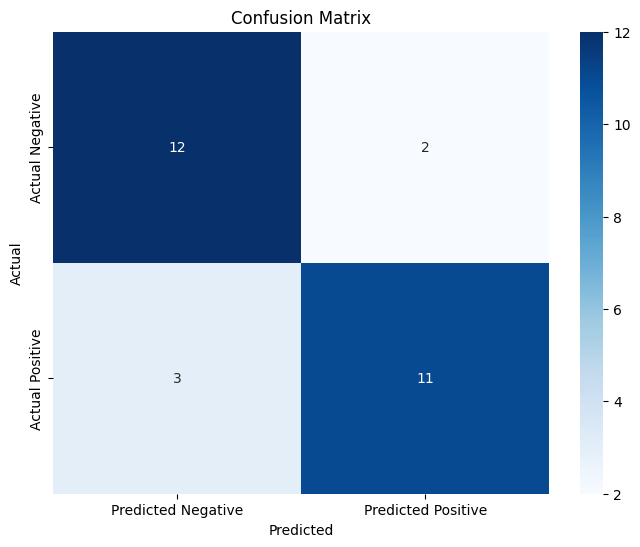

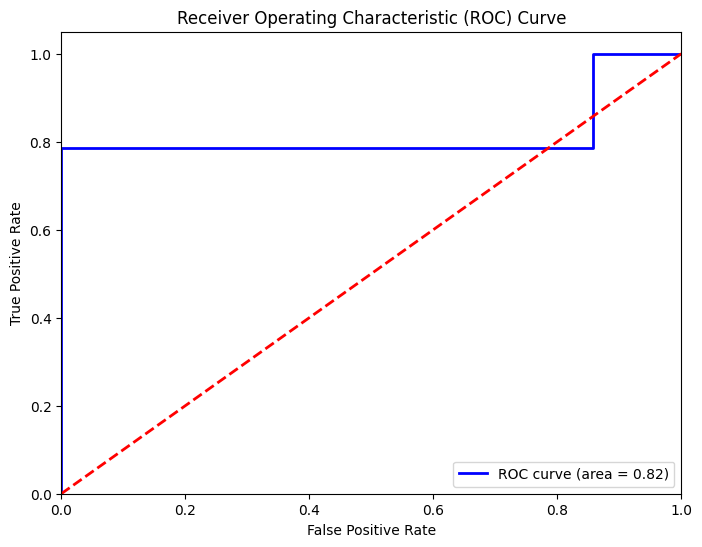

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_confusion_matrix_and_roc(TP, TN, FP, FN):
    cm = np.array([[TN, FP],
                   [FN, TP]])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    y_true = [1] * TP + [0] * TN + [1] * FN + [0] * FP  
    y_scores = [0.9] * TP + [0.7] * TN + [0.4] * FN + [0.3] * FP

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_confusion_matrix_and_roc(TP, TN, FP, FN)